In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.metrics import sensitivity_specificity_support
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from itertools import cycle
import time

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
#기존 데이터 - training set에 맞춘 descriptor
#association_data = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/7_new_association/9_gold_learning_association.tsv")
#descriptor_data = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/2_1_descriptor_combined.tsv", header=None) # 이거 현재 바뀜.
df = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/2_1_descriptor_combined.tsv")
x_whole_data = df[df.columns.values[3:].tolist()].values
y_whole_data = df["association"].values

In [6]:
#2017.3.15.
df = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/7_2_1_tn_whole_descriptor_removed.tsv")
x_whole_data = df[df.columns.values[3:].tolist()].values
y_whole_data = df["association"].values

In [2]:
#2017.3.14.
df = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/6_2_1_tn_whole_descriptor.tsv")
x_whole_data = df[df.columns.values[3:].tolist()].values
y_whole_data = df["association"].values

In [2]:
#2017.3.9.
df = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/2_1_2_new_descriptor.tsv")
x_whole_data = df[df.columns.values[3:].tolist()].values
y_whole_data = df["association"].values

In [5]:
# new descriptor - TN 구분한 data(2017.1.16.) 수정됨. 2017.1.23.
df = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/4_gold_descriptor_revised_1%.tsv")
x_whole_data_1 = df[df.columns.values[3:].tolist()].values
y_whole_data_1 = df["association"].values

# new descriptor - TN 구분한 data(2017.1.16.) 수정됨. 2017.1.23. 추가됨 2017.2.1.
df = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/4_gold_descriptor_revised_0.5%.tsv")
x_whole_data_0_5 = df[df.columns.values[3:].tolist()].values
y_whole_data_0_5 = df["association"].values

df = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/4_gold_descriptor_revised_0.1%.tsv")
x_whole_data_0_1 = df[df.columns.values[3:].tolist()].values
y_whole_data_0_1 = df["association"].values

In [7]:
#그래프도 그리는 거. 2017.2.23.작성

from sklearn.metrics import roc_curve, auc, average_precision_score
def Logist_Regression_10_fold(x_whole_data, y_whole_data, user_c):
    print("{}----------------------------------------------------\r\n".format(user_c))
    skf = StratifiedKFold(n_splits=10, shuffle=True) # n_splits = 10 (10 fold라서.) data가 nega : pos = 76 : 1이기 때문에 validation 뽑을때 그 비율 지켜서 stratified로 한다.
    whole_accuracy = list()
    whole_auc = list()
    whole_aupr = list()
    whole_confusion_mat = list()
    whole_precision = list()
    whole_recall = list()
    whole_sn = list()
    whole_sp = list()
    
    colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange', 'red', 'violet', 'fuchsia', 'sienna'])
    lw = 2
    plt.clf()
    f, axes = plt.subplots(1, 2, figsize=(15, 5))
    i=0
    
    
    for (training_index, validation_index), color in zip(skf.split(x_whole_data, y_whole_data), colors):
        #print("{}----------------------------------------------------".format(user_c))
        x_training_set = x_whole_data[training_index] # 0.9에 해당하는 부분
        y_training_set = y_whole_data[training_index]
        x_validation_set = x_whole_data[validation_index] # 0.1에 해당하는 부분
        y_validation_set = y_whole_data[validation_index]
        
        classifier = LogisticRegression(penalty='l1', C=user_c, n_jobs=-1) #n_jobs = -1이면 모든 node 쓰는것. 신경쓰이면 30개 정도.
        #classifier = RandomForestClassifier(n_estimators=120, n_jobs=-1, class_weight='balanced')
        #classifier = LinearSVC(penalty='l1', C=user_c, class_weight='balanced', dual=True, loss='hinge')
        classifier.fit(x_training_set, y_training_set)
        y_predicted_proba = classifier.predict_proba(x_validation_set) # return값이 probability 각각에 대한 확률 결과값 [[0.8(0에대한 확률),0.2(1에대한 확률)],[0.7,0.3],... ]
        y_predicted_label = classifier.predict(x_validation_set) # return이 label임. 위 확률 결과에서 확률이 높은거에 대한 label을 보여줌.

        current_accuracy = classifier.score(x_validation_set, y_validation_set) # accuracy score를 보여줌.
        fpr, tpr, thresholds = roc_curve(y_validation_set, y_predicted_proba[:, 1], pos_label=1) # positive label만 본것., tpr = sensitivity, recall
        sn, sp, _ = sensitivity_specificity_support(y_validation_set, y_predicted_label)
        current_auc = auc(fpr, tpr)
        precision, recall, _, _ = precision_recall_fscore_support(y_validation_set, y_predicted_label, average = 'binary')
        current_aupr = average_precision_score(y_validation_set, y_predicted_proba[:, 1])
        current_confusion_matrix = confusion_matrix(y_validation_set,y_predicted_label)
        precision_vec, recall_vec, _ = precision_recall_curve(y_validation_set, y_predicted_proba[:, 1]) #전체 precision과 recall 보고 싶을때,
    
        # plot AUC
        lab1 = 'Fold %d AUC=%.4f' % (i+1, current_auc)
        axes[0].plot(fpr, tpr, lw=lw, color=color, label=lab1)
        
        # plot AUPR
        lab2 = 'Fold %d AUPR=%.4f' % (i+1, current_aupr)
        axes[1].plot(recall_vec, precision_vec, lw=lw, color=color, label=lab2)
        
        i += 1
        
        whole_accuracy.append(current_accuracy)
        whole_auc.append(current_auc)
        whole_sn.append(sn)
        whole_sp.append(sp)
        whole_aupr.append(current_aupr)
        whole_precision.append(precision)
        whole_recall.append(recall)
        whole_confusion_mat.append((current_confusion_matrix))
        # end of for loop 
    avg_acc = sum(whole_accuracy)/len(whole_accuracy)
    avg_auc = sum(whole_auc)/len(whole_auc)
    avg_aupr = sum(whole_aupr)/len(whole_aupr)
    avg_sn = sum(whole_sn) / len(whole_sn)
    avg_sp = sum(whole_sp) / len(whole_sp)
    avg_precision = sum(whole_precision) / len(whole_precision)
    avg_recall = sum(whole_recall) / len(whole_recall)
    sum_confusion_matrix = sum(whole_confusion_mat)
    
    axes[0].set_xlabel('FPR')
    axes[0].set_ylabel('TPR')
    axes[0].set_ylim([0.0, 1.05])
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_title('Average AUC={0:0.2f}'.format(avg_auc))
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_title('Average AUPR={0:0.2f}'.format(avg_aupr))
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    f.subplots_adjust(wspace=0.8)
    
    plt.show()
    
    return [avg_acc, avg_auc, avg_aupr, sum_confusion_matrix, avg_sn, avg_sp, avg_precision, avg_recall]   


In [6]:
from sklearn.metrics import roc_curve, auc, average_precision_score

def Logist_Regression_10_fold(x_whole_data, y_whole_data, user_c):
    skf = StratifiedKFold(n_splits=10, shuffle=True) # n_splits = 10 (10 fold라서.) data가 nega : pos = 76 : 1이기 때문에 validation 뽑을때 그 비율 지켜서 stratified로 한다.
    whole_accuracy = list()
    whole_auc = list()
    whole_aupr = list()
    whole_confusion_mat = list()
    for training_index, validation_index in skf.split(x_whole_data, y_whole_data):
        #print("{}----------------------------------------------------".format(user_c))
        x_training_set = x_whole_data[training_index] # 0.9에 해당하는 부분
        y_training_set = y_whole_data[training_index]
        x_validation_set = x_whole_data[validation_index] # 0.1에 해당하는 부분
        y_validation_set = y_whole_data[validation_index]

        classifier = LogisticRegression(penalty='l1', C=user_c, n_jobs=-1) #n_jobs = -1이면 모든 node 쓰는것. 신경쓰이면 30개 정도.
        #classifier = RandomForestClassifier(n_estimators=120, n_jobs=-1, class_weight='balanced')
        #classifier = LinearSVC(penalty='l1', C=user_c, class_weight='balanced', dual=True, loss='hinge')
        classifier.fit(x_training_set, y_training_set)
        y_predicted_proba = classifier.predict_proba(x_validation_set) # return값이 probability 각각에 대한 확률 결과값 [[0.8(0에대한 확률),0.2(1에대한 확률)],[0.7,0.3],... ]
        y_predicted_label = classifier.predict(x_validation_set) # return이 label임. 위 확률 결과에서 확률이 높은거에 대한 label을 보여줌.

        current_accuracy = classifier.score(x_validation_set, y_validation_set) # accuracy score를 보여줌.
        fpr, tpr, thresholds = roc_curve(y_validation_set, y_predicted_proba[:, 1], pos_label=1) # powitive label만 본것.
        current_auc = auc(fpr, tpr)
        current_confusion_matrix = confusion_matrix(y_validation_set,
                                                    y_predicted_label)
        current_aupr = average_precision_score(y_validation_set, y_predicted_proba[:, 1])
    
        whole_accuracy.append(current_accuracy)
        whole_auc.append(current_auc)
        whole_aupr.append(current_aupr)
        whole_confusion_mat.append((current_confusion_matrix))
        
        #print("Accuracy of this fold: {}".format(current_accuracy))
        #print("AUC of this fold: {}".format(current_auc))
        #print("AUPR of this fold: {}".format(current_aupr))
        #print("Confustion matrix of this fold")
        #print(current_confusion_matrix)
        #print("\n")
    avg_acc = sum(whole_accuracy)/len(whole_accuracy)
    avg_auc = sum(whole_auc)/len(whole_auc)
    avg_aupr = sum(whole_aupr)/len(whole_aupr)
    sum_confusion_matrix = sum(whole_confusion_mat)
    #print("Accuracy avg : {}").format(sum(whole_accuracy)/len(whole_accuracy))
    #print("AUC avg : {}").format(sum(whole_auc)/len(whole_auc))
    #print("AUPR avg : {}").format(sum(whole_aupr)/len(whole_aupr))
    #print("Confustion matrix")
    #print(sum(whole_confusion_mat))
    
    return [avg_acc, avg_auc, avg_aupr, sum_confusion_matrix]   
    #return [whole_accuracy, whole_auc, whole_aupr, whole_confusion_mat]

In [8]:
def write_output(filedescritor, results):
    f.write("Accuracy avg : {}\r\n".format(results[0]))
    f.write("AUC avg : {}\r\n".format(results[1]))
    f.write("  Sensitivity avg : {}\r\n".format(results[4]))
    f.write("  Specificity avg : {}\r\n".format(results[5]))
    f.write("AUPR avg : {}\r\n".format(results[2]))
    f.write("  Precision avg : {}\r\n".format(results[6]))
    f.write("  Recall avg : {}\r\n".format(results[7]))
    f.write("confusion amtrix : {}\r\n".format(results[3]))

Wed 20:49:06
0.0001----------------------------------------------------



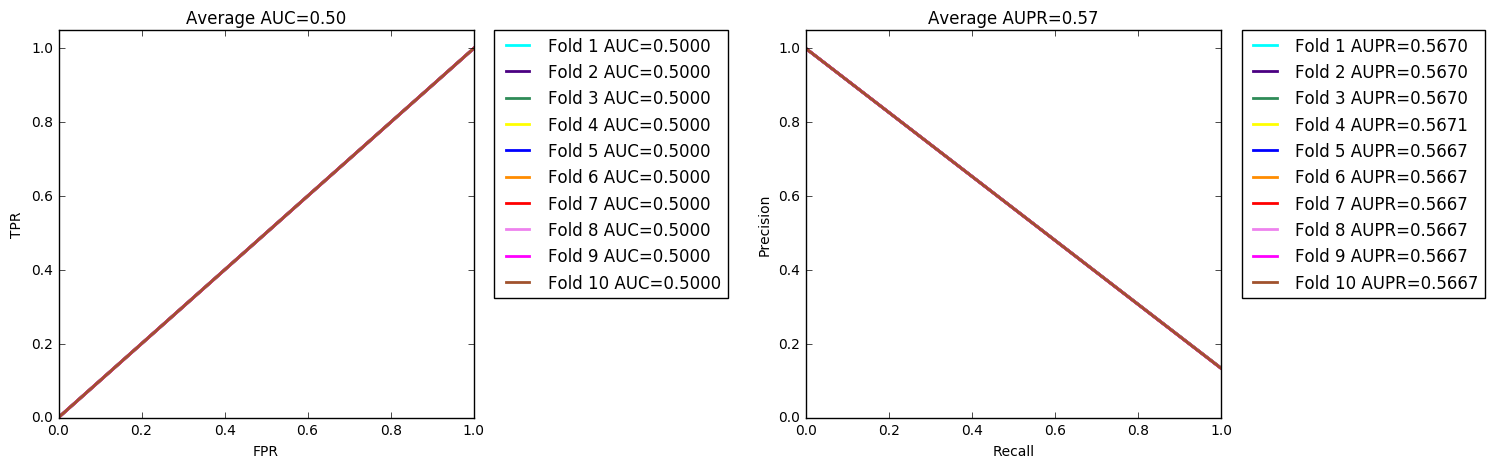

0.001----------------------------------------------------



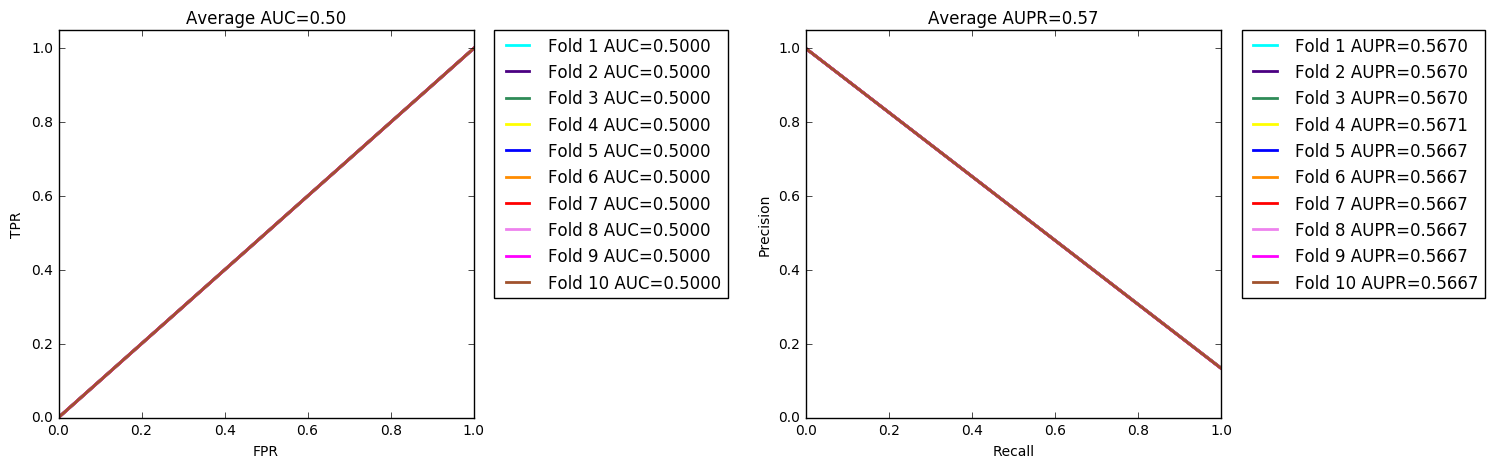

0.01----------------------------------------------------



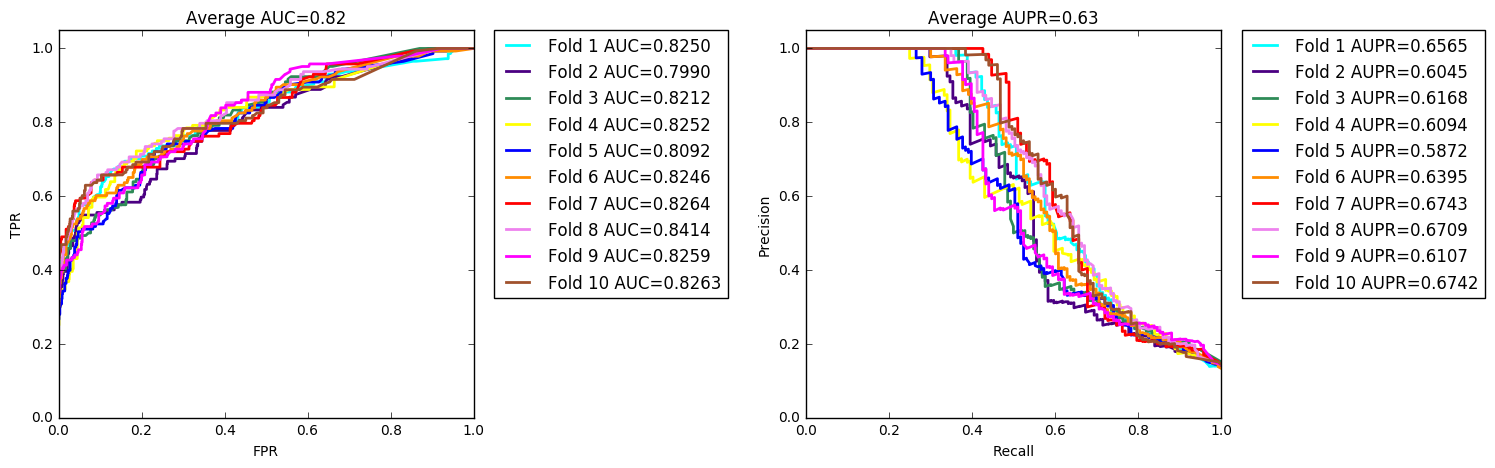

0.1----------------------------------------------------



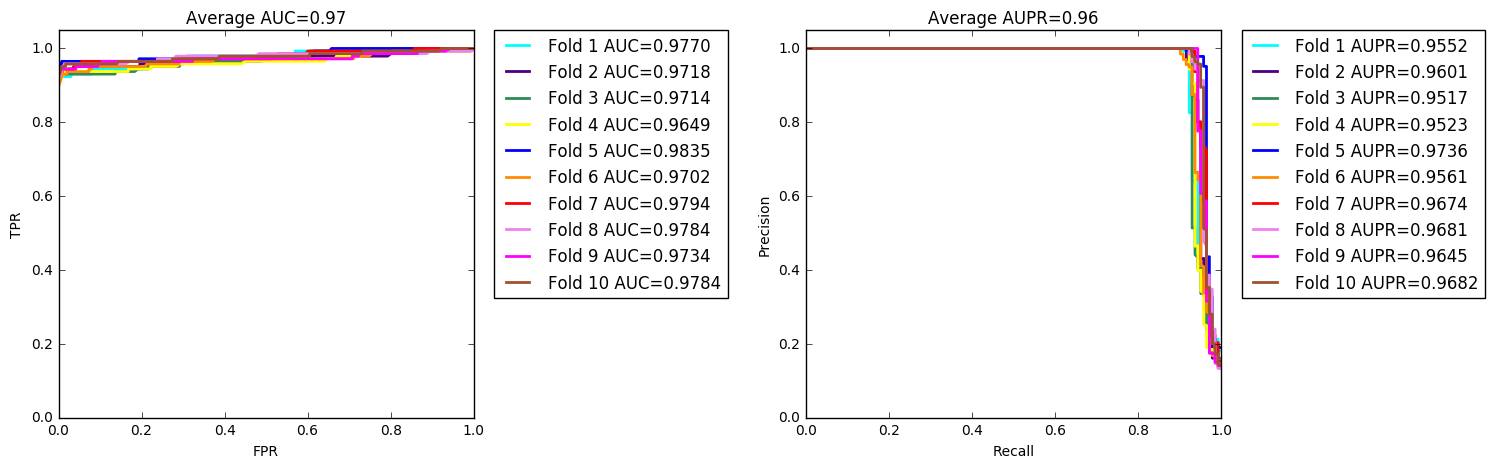

1----------------------------------------------------



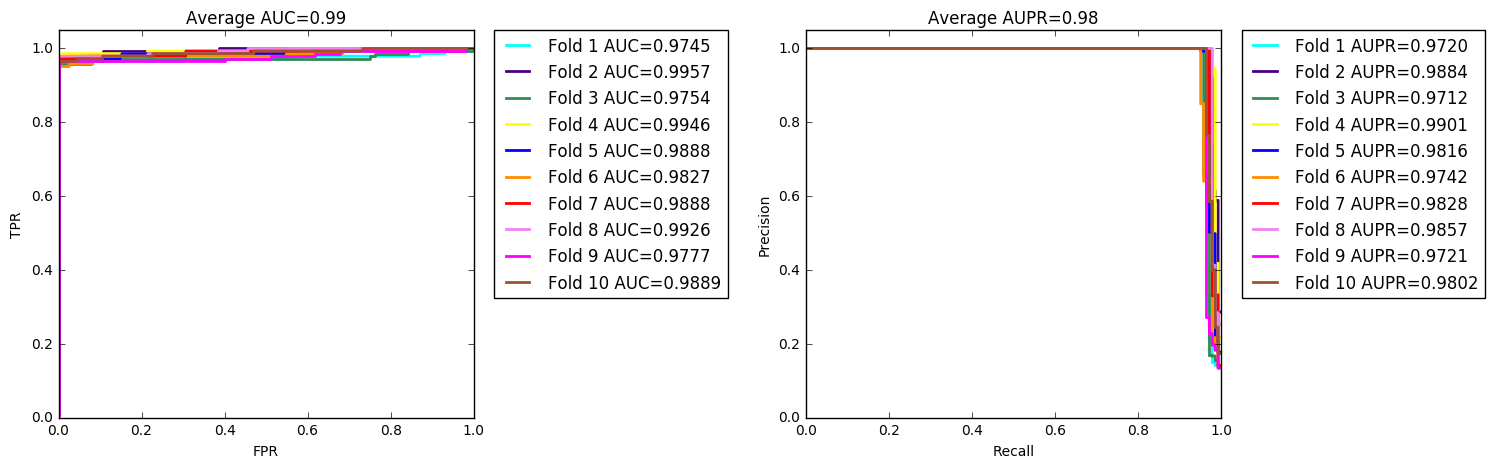

10----------------------------------------------------



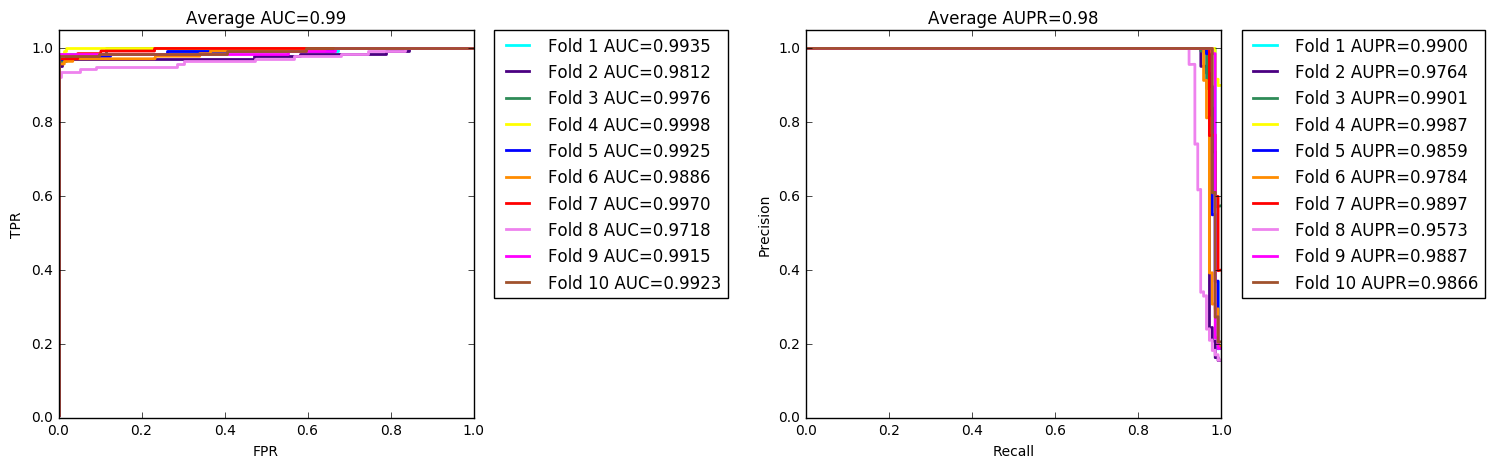

100----------------------------------------------------



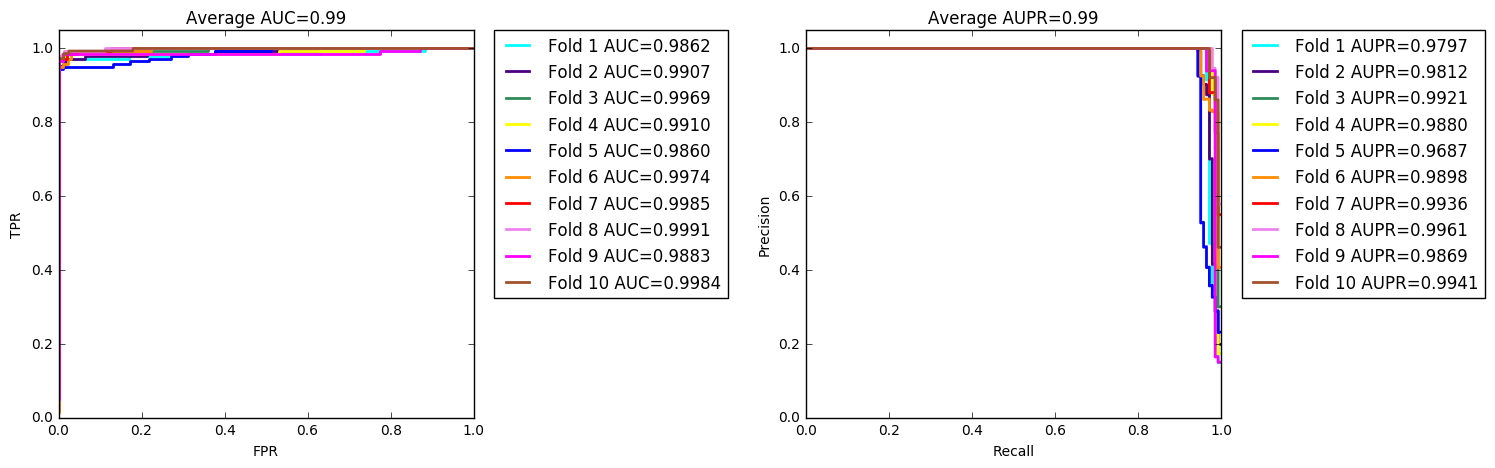

1000----------------------------------------------------



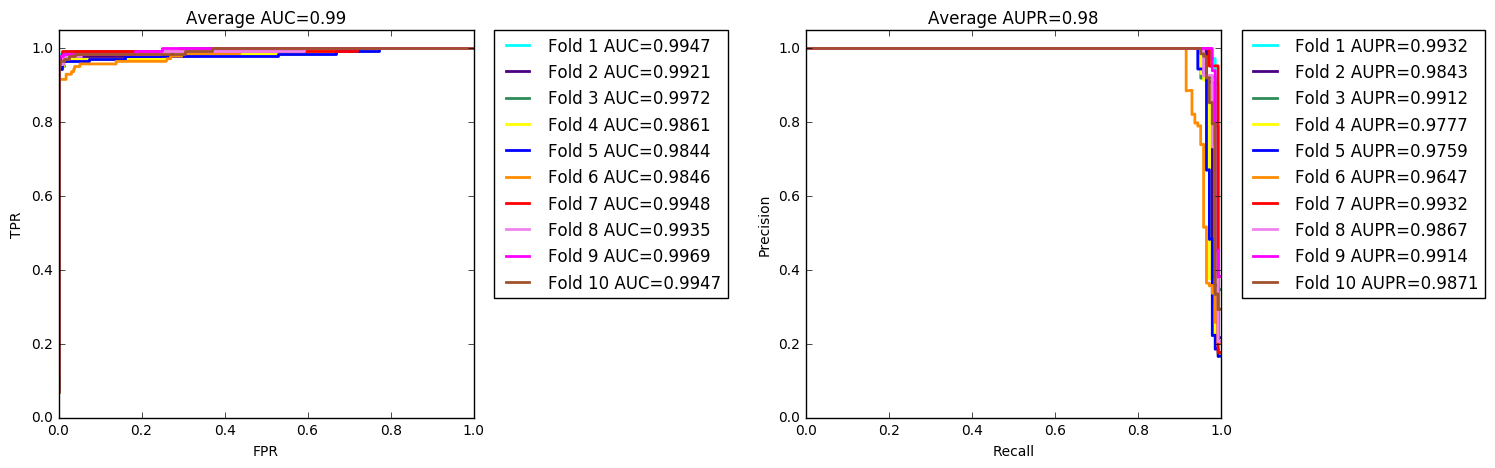

10000----------------------------------------------------



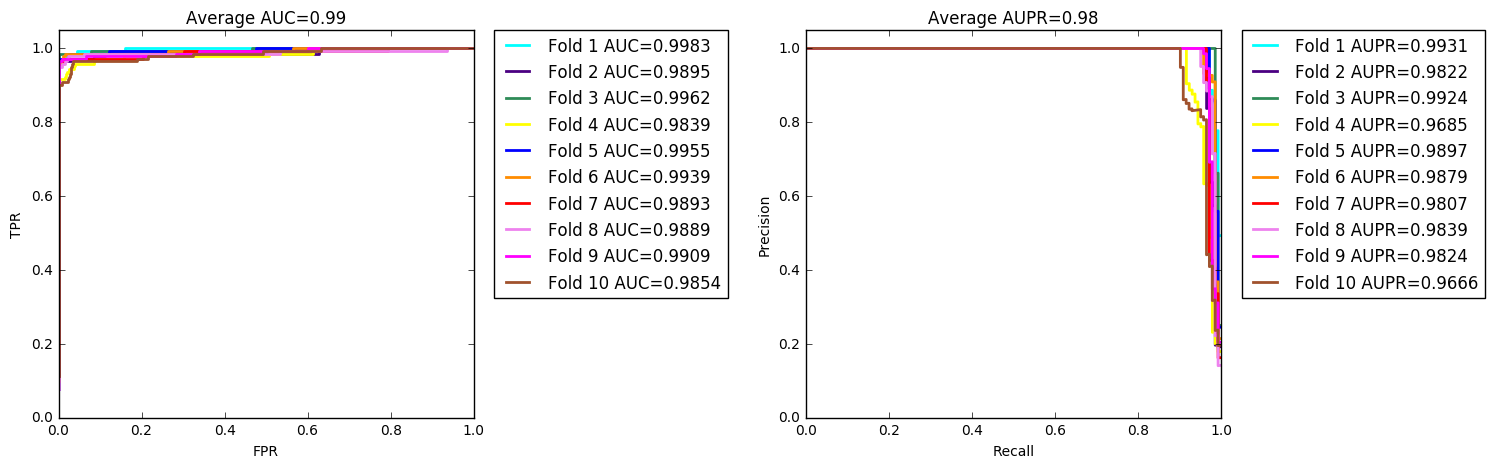

Wed 20:50:34


In [9]:
# removed descriptor, tn(whole) 10-fold, 2017.3.15. 작성
print time.strftime('%a %H:%M:%S')
with open("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/Performance/1_9_LR_removed_TN_whole_10-fold.txt", 'w') as f :
    for user_c in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]:
        results = Logist_Regression_10_fold(x_whole_data, y_whole_data, user_c)
        f.write("{}----------------------------------------------------\r\n".format(user_c))
        write_output(f, results)
        
print time.strftime('%a %H:%M:%S')

Wed 20:03:53
0.0001----------------------------------------------------



/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


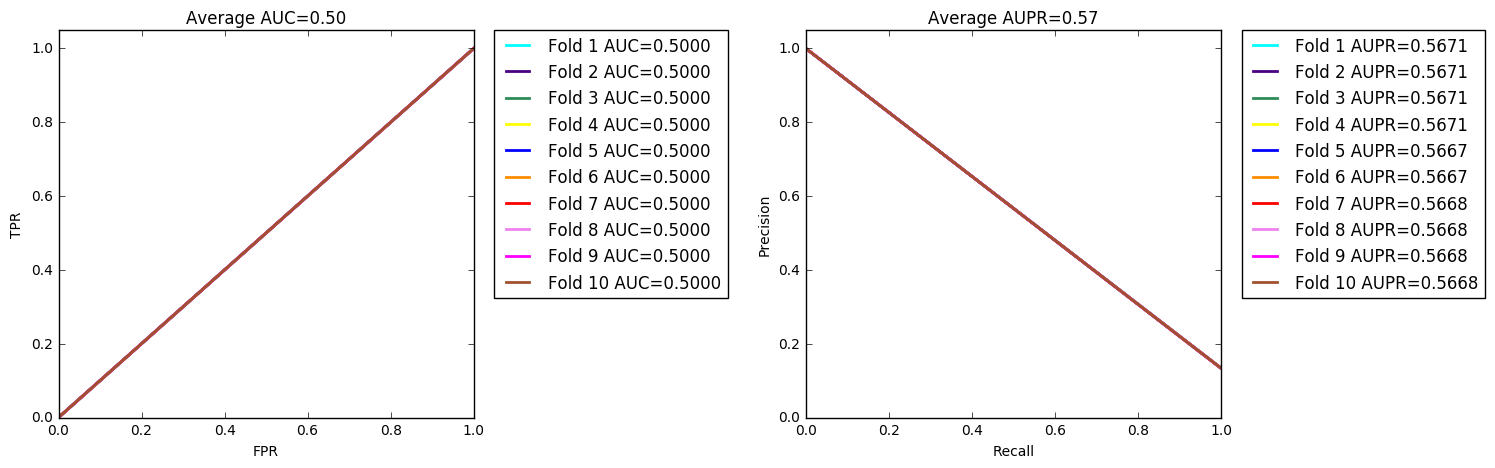

0.001----------------------------------------------------



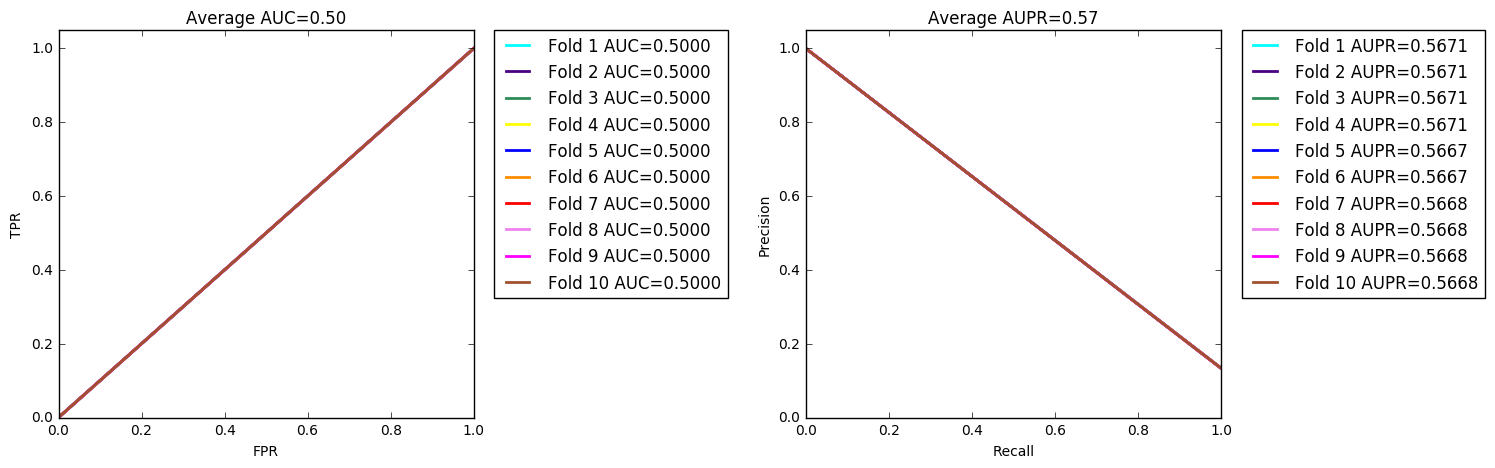

0.01----------------------------------------------------



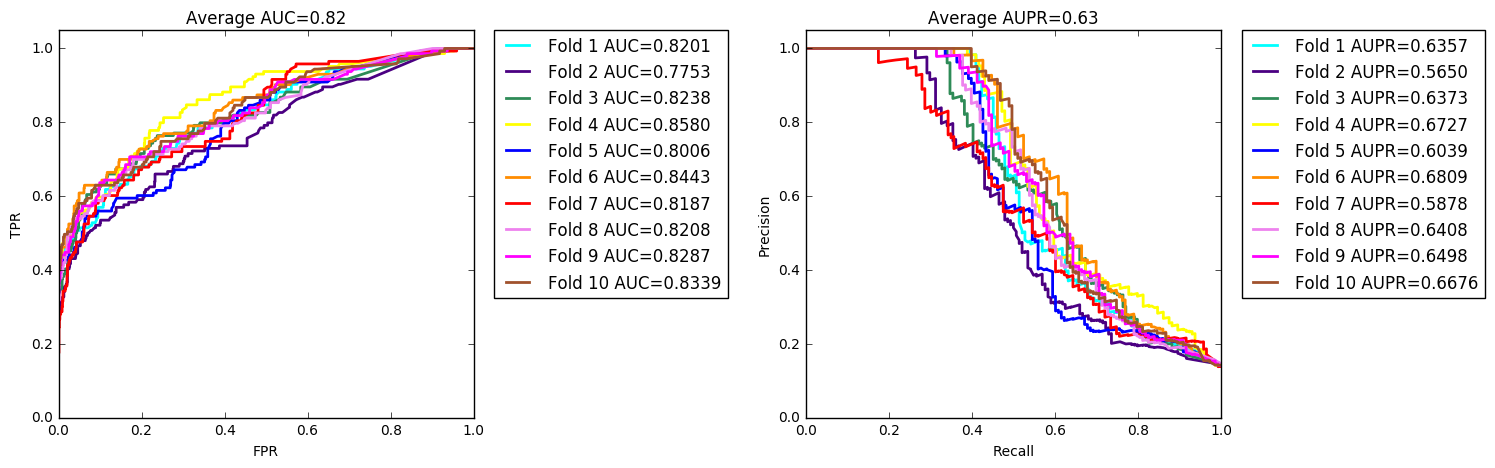

0.1----------------------------------------------------



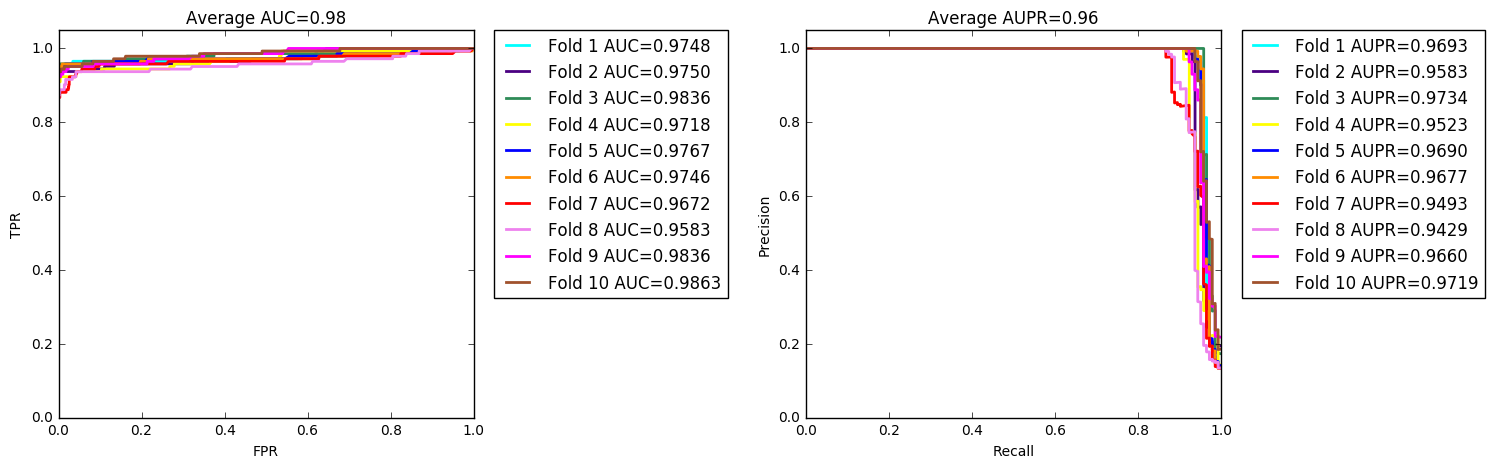

1----------------------------------------------------



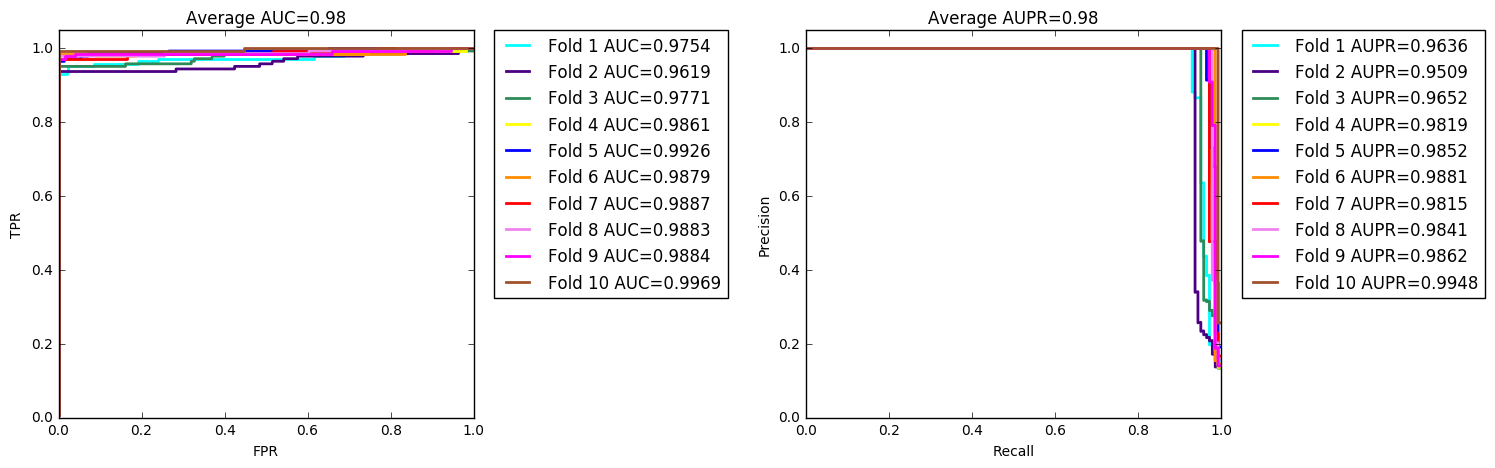

10----------------------------------------------------



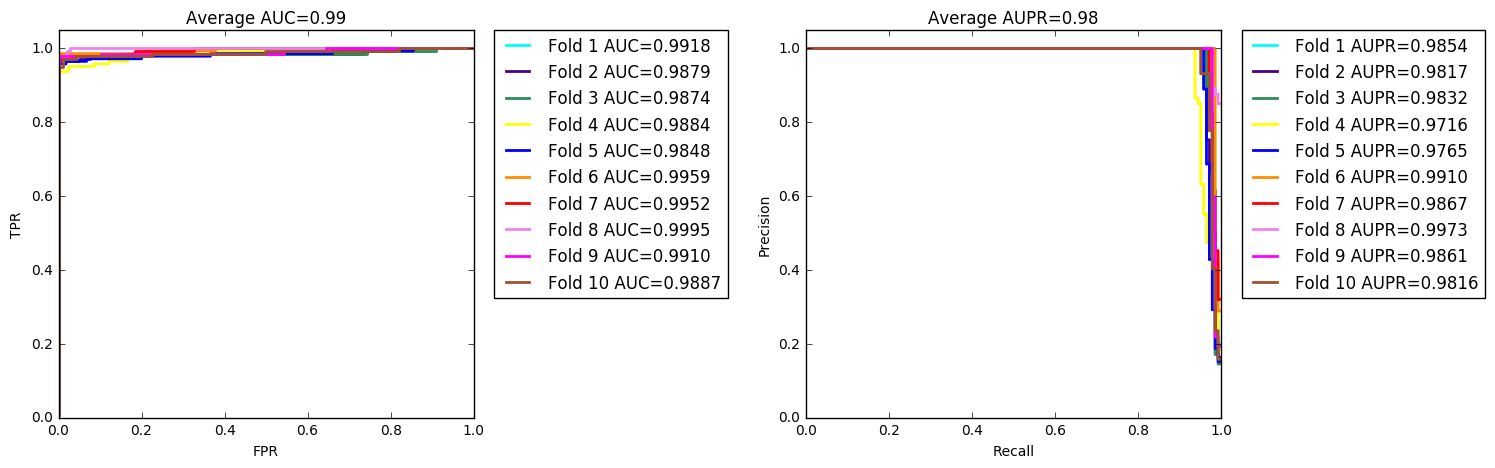

100----------------------------------------------------



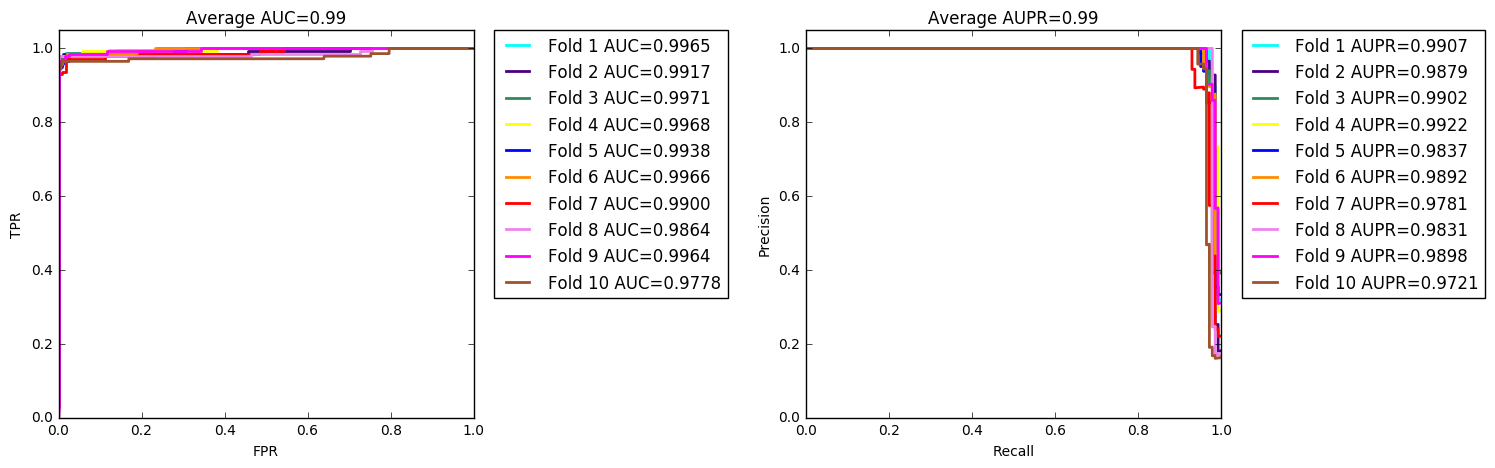

1000----------------------------------------------------



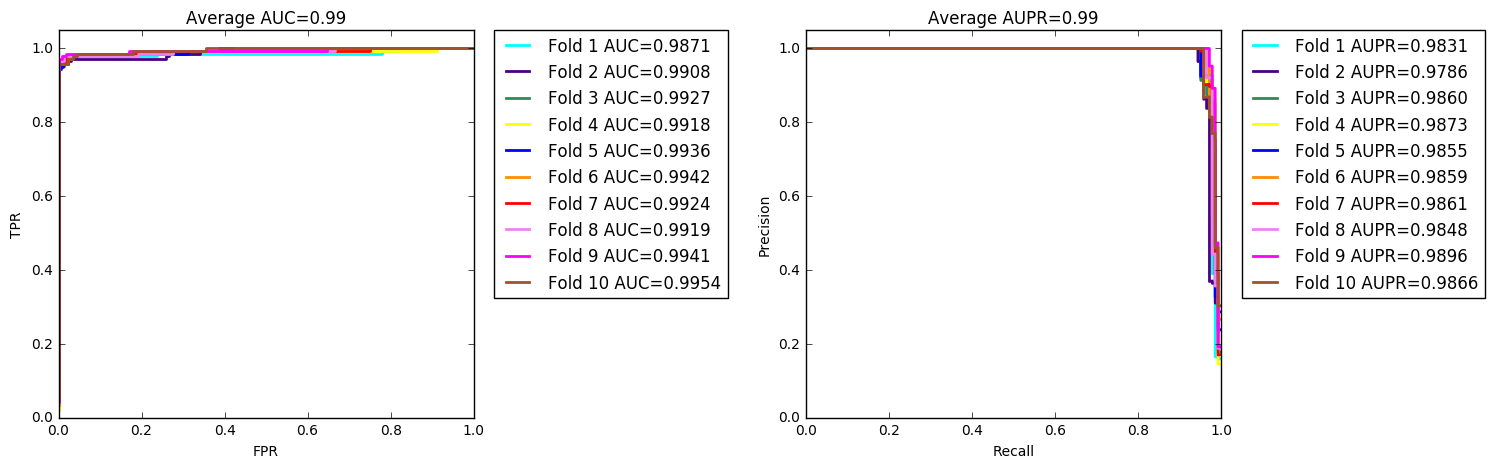

10000----------------------------------------------------



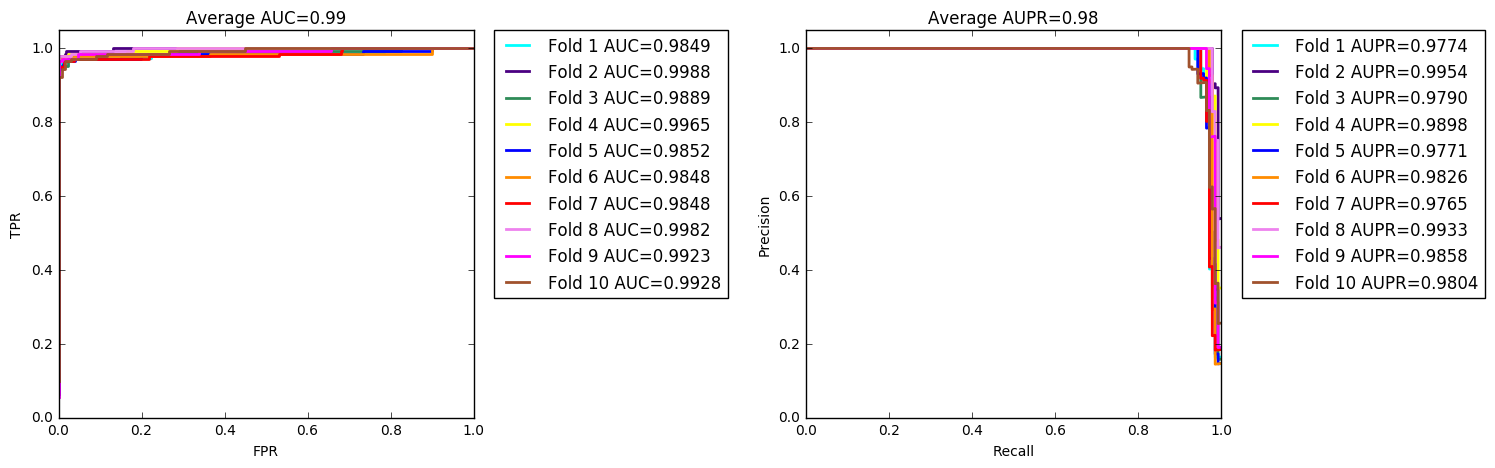

Wed 20:08:29


In [5]:
# 원래 descriptor, tn(whole) 10-fold, 2017.3.14. 작성
print time.strftime('%a %H:%M:%S')
with open("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/Performance/1_8_LR_original_TN_whole_10-fold.txt", 'w') as f :
    for user_c in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]:
        results = Logist_Regression_10_fold(x_whole_data, y_whole_data, user_c)
        f.write("{}----------------------------------------------------\r\n".format(user_c))
        write_output(f, results)
        
print time.strftime('%a %H:%M:%S')

Thu 20:14:51


/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


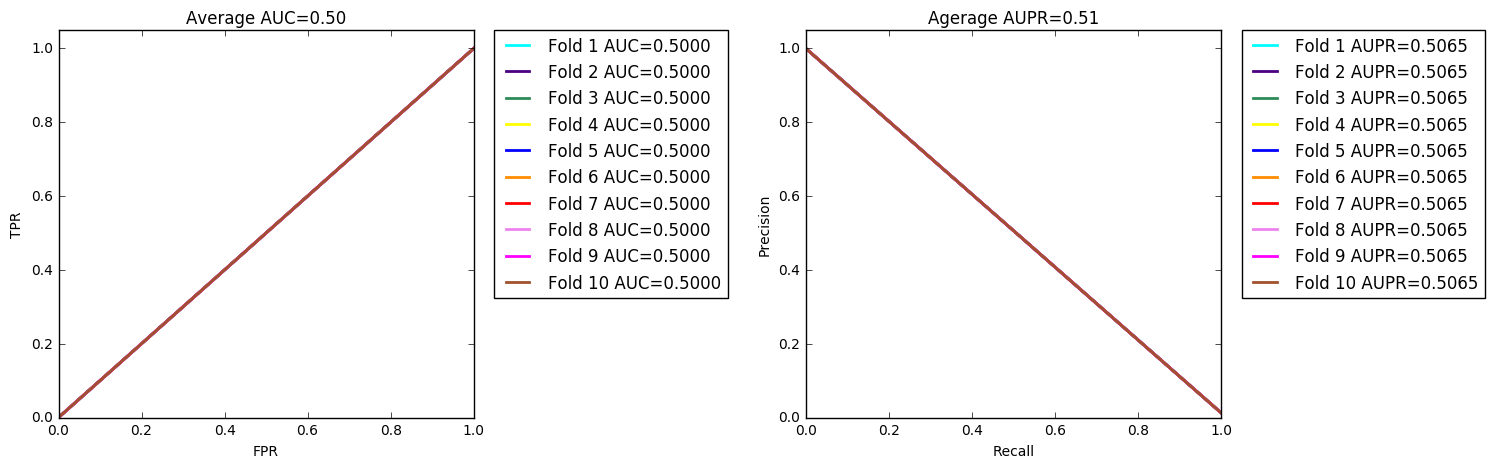

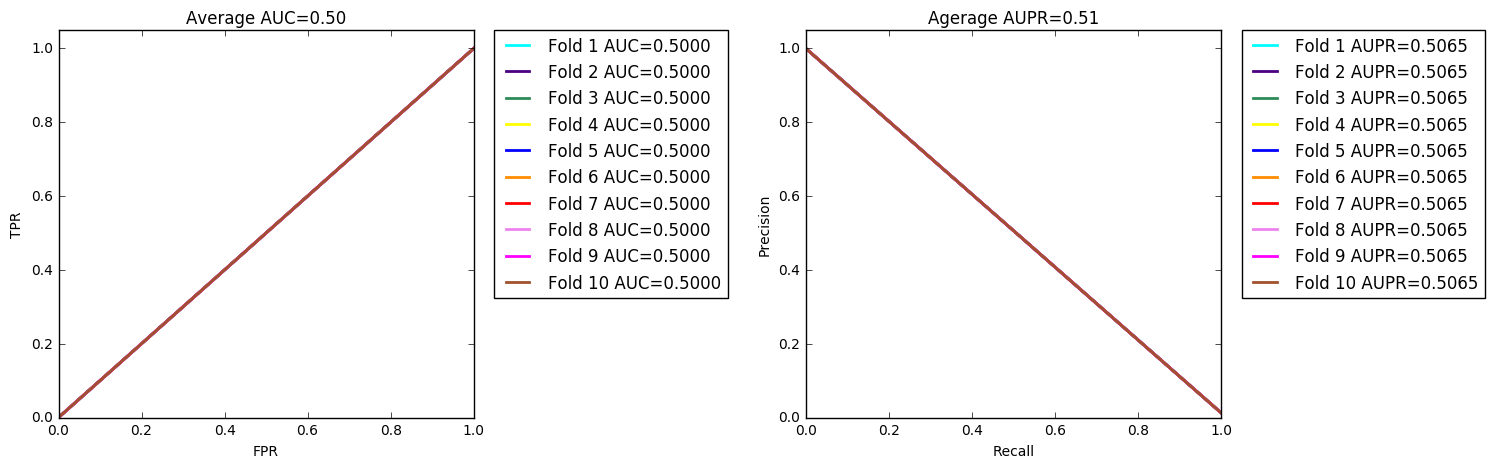

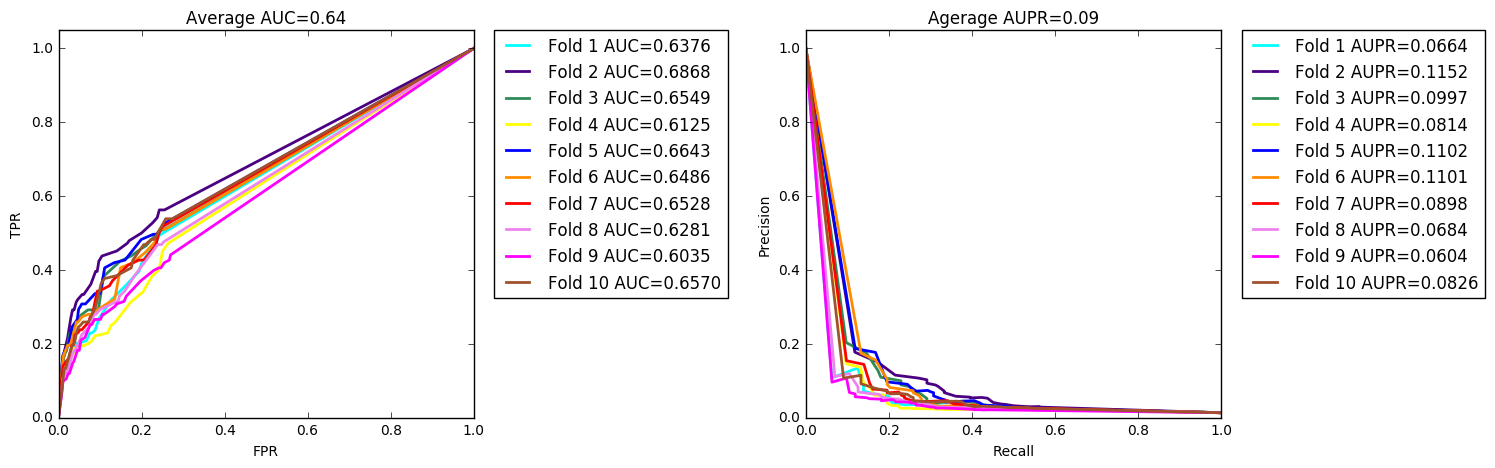

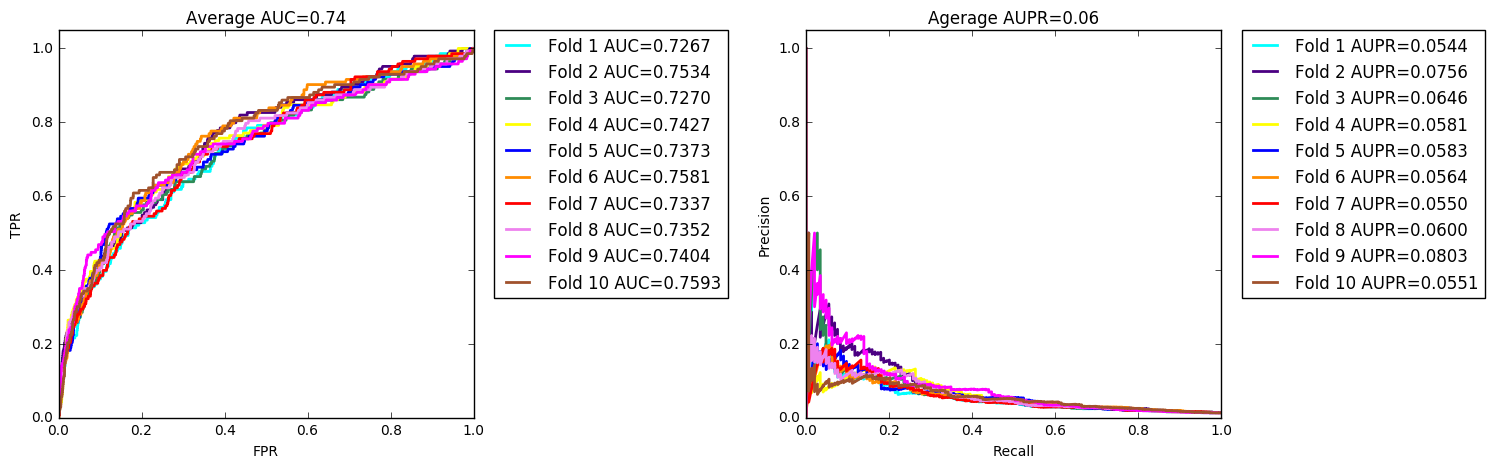

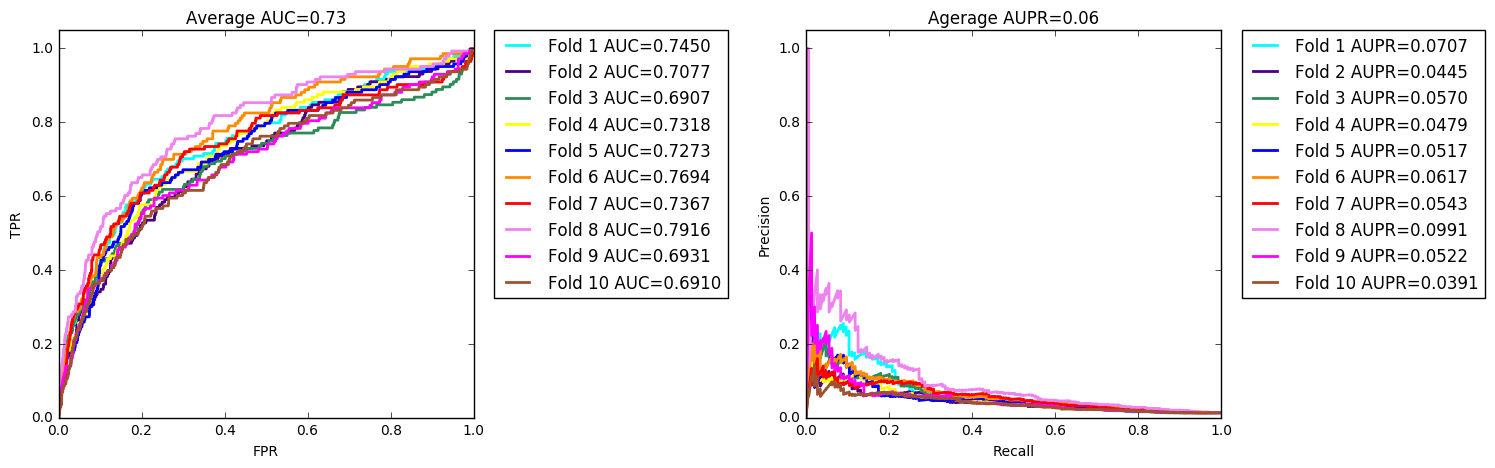

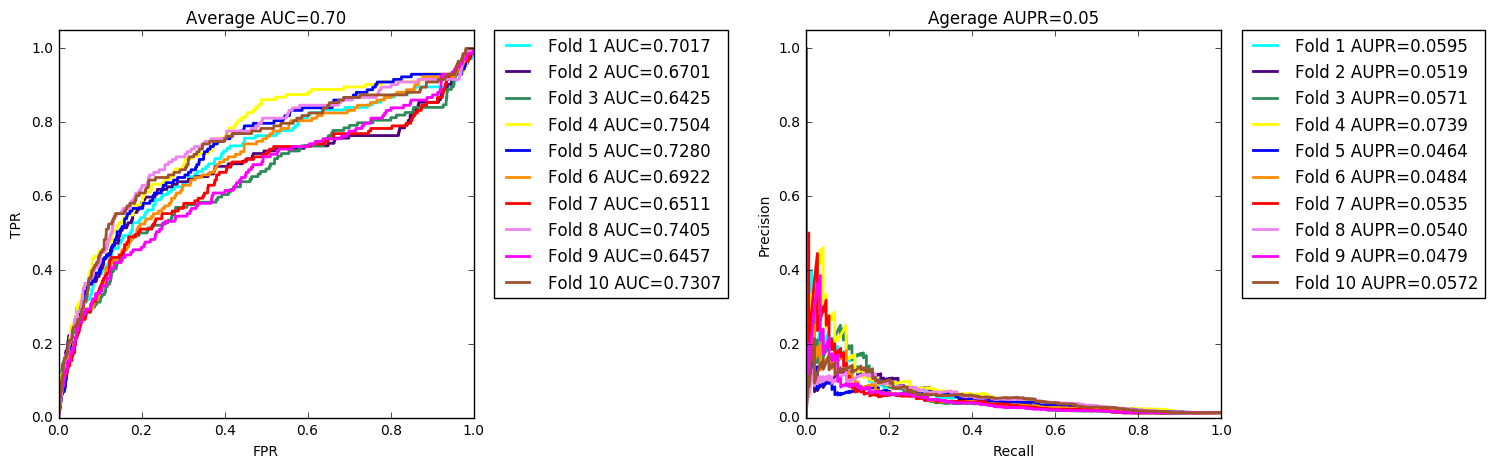

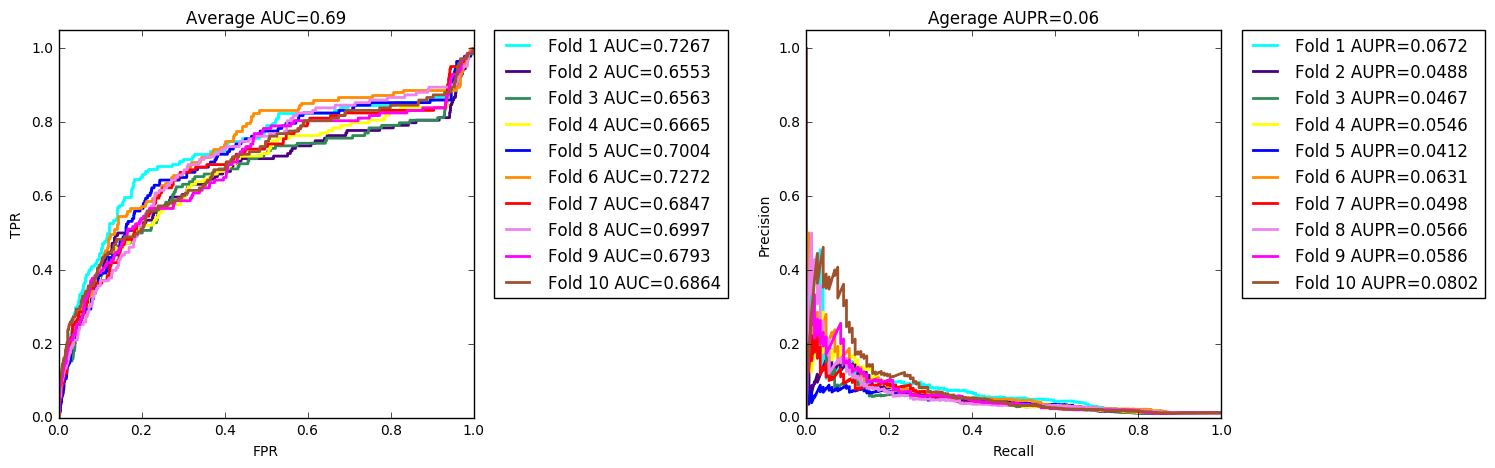

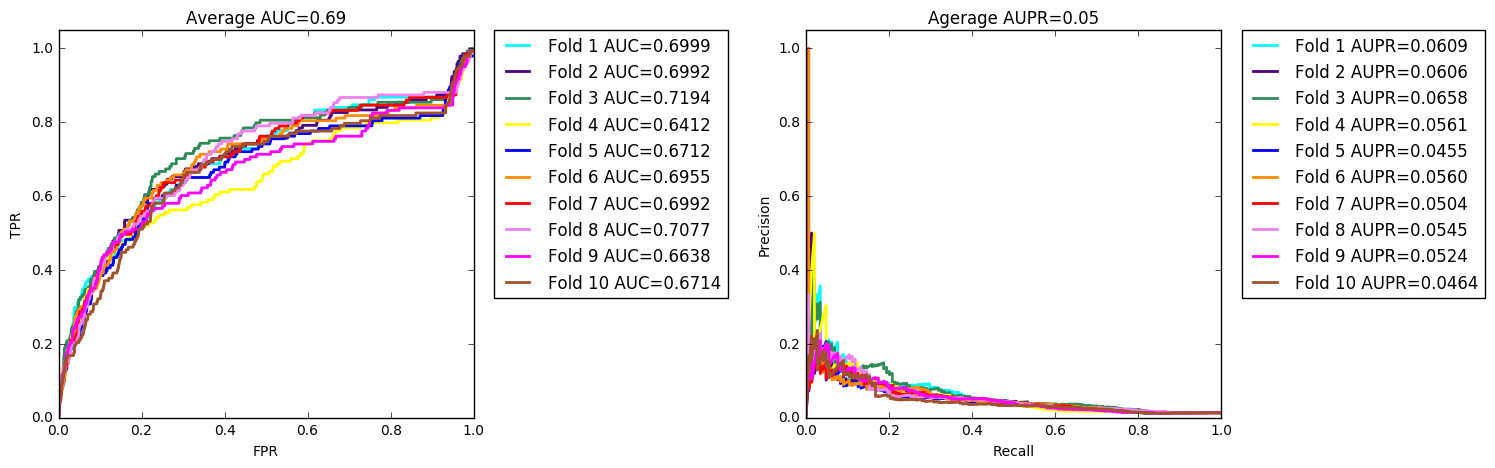

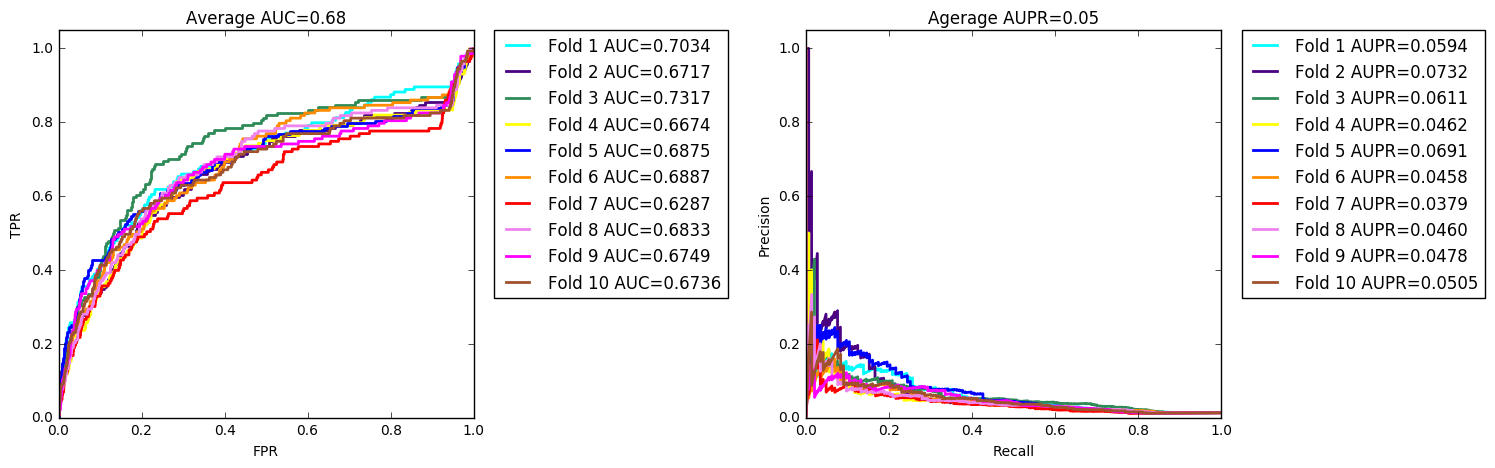

Thu 22:55:01


In [5]:
# new descriptor(independet에 맞춘거), 10-fold, 2017.3.9. 작성
print time.strftime('%a %H:%M:%S')
with open("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/1_6_LR_removed_10-fold.txt", 'w') as f :
    for user_c in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]:
        results = Logist_Regression_10_fold(x_whole_data, y_whole_data, user_c)
        f.write("{}----------------------------------------------------\r\n".format(user_c))
        write_output(f, results)
        
print time.strftime('%a %H:%M:%S')

Fri 01:36:04


/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


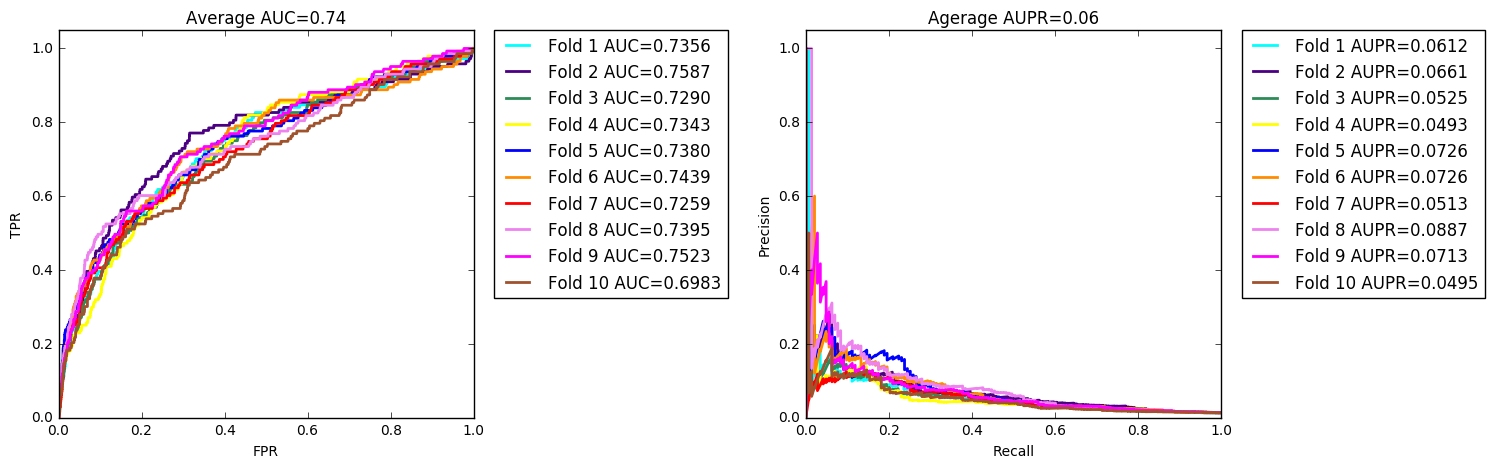

Fri 01:38:28


In [7]:
# 기존 dataset, 10-fold, 2017.2.24. 작성.
print time.strftime('%a %H:%M:%S')
with open("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/1_1_LR_original_10-fold_2.txt", 'w') as f :
    #for user_c in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]:
    #    results = Logist_Regression_10_fold(x_whole_data, y_whole_data, user_c)
    #    f.write("{}----------------------------------------------------\r\n".format(user_c))
    #    write_output(f, results)
    user_c = 0.1
    results = Logist_Regression_10_fold(x_whole_data, y_whole_data, user_c)
    f.write("{}----------------------------------------------------\r\n".format(user_c))
    write_output(f, results)
    
print time.strftime('%a %H:%M:%S')

Fri 02:02:11


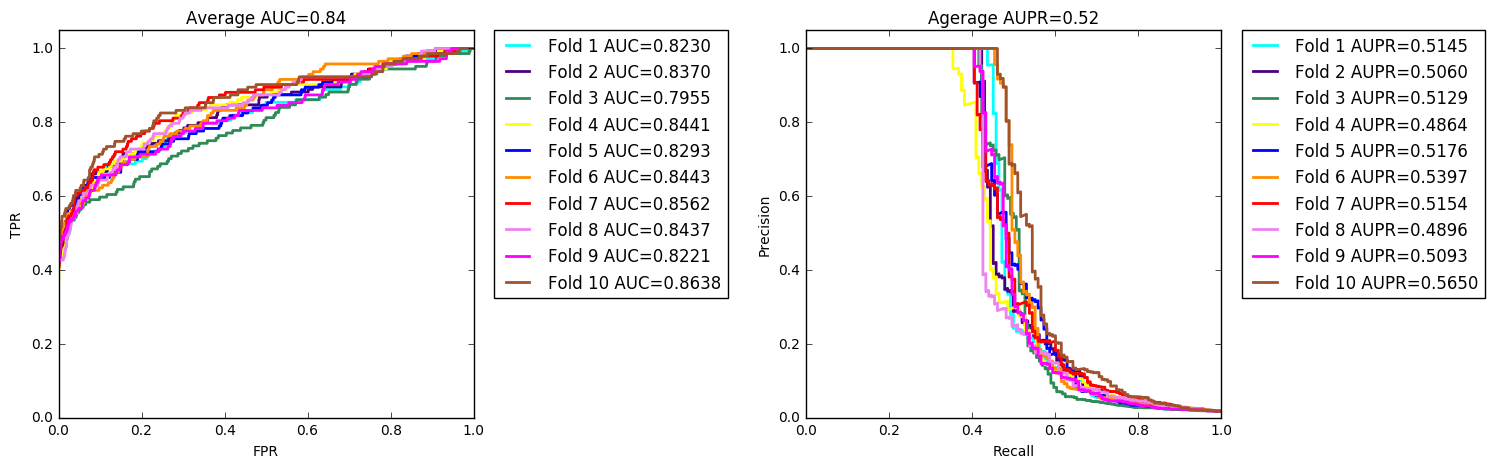

Fri 02:06:04


In [10]:
# undersampling(0.1%) dataset, 10-fold, 2017.2.23. 작성.
print time.strftime('%a %H:%M:%S')
with open("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/1_1_LR_feature_based(0.1%)_10-fold_2.txt", 'w') as f :
    #for user_c in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]:
    #    results = Logist_Regression_10_fold(x_whole_data, y_whole_data, user_c)
    #    f.write("{}----------------------------------------------------\r\n".format(user_c))
    #    write_output(f, results)
    user_c = 1
    results = Logist_Regression_10_fold(x_whole_data_0_1, y_whole_data_0_1, user_c)
    f.write("{}----------------------------------------------------\r\n".format(user_c))
    write_output(f, results)
    
print time.strftime('%a %H:%M:%S')

In [ ]:
# undersampling(0.1%) dataset, 10-fold, 2017.2.23. 작성.
print time.strftime('%a %H:%M:%S')
with open("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/1_1_original_10-fold__0_01_ver2.txt", 'w') as f :
    #for user_c in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]:
    #    results = Logist_Regression_10_fold(x_whole_data, y_whole_data, user_c)
    #    f.write("{}----------------------------------------------------\r\n".format(user_c))
    #    write_output(f, results)
    user_c = 1
    results = Logist_Regression_10_fold(x_whole_data_0_1, y_whole_data_0_1, user_c)
    f.write("{}----------------------------------------------------\r\n".format(user_c))
    write_output(f, results)
    
print time.strftime('%a %H:%M:%S')

In [9]:
# undersampling dataset(1%), 10-fold, 2017.2.14. 작성.
print time.strftime('%a %H:%M:%S')
with open("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/1_2_feature_based(1%)_10-fold.txt", 'w') as f :
    for user_c in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]:
        results = Logist_Regression_10_fold(x_whole_data_1, y_whole_data_1, user_c)
        f.write("{}----------------------------------------------------\r\n".format(user_c))
        write_output(f, results)
print time.strftime('%a %H:%M:%S')

Tue 19:50:23
Tue 20:19:31


In [10]:
# undersampling dataset(1%), 10-fold, 2017.2.14. 작성.
print time.strftime('%a %H:%M:%S')
with open("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/1_3_featrue_based(0.5%)_10-fold.txt", 'w') as f :
    for user_c in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]:
        results = Logist_Regression_10_fold(x_whole_data_0_5, y_whole_data_0_5, user_c)
        f.write("{}----------------------------------------------------\r\n".format(user_c))
        write_output(f, results)
print time.strftime('%a %H:%M:%S')

Tue 20:19:31
Tue 20:56:49


In [11]:
# undersampling dataset(1%), 10-fold, 2017.2.14. 작성.
print time.strftime('%a %H:%M:%S')
with open("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/1_4_feature_based(0.1%)_10-fold.txt", 'w') as f :
    for user_c in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]:
        results = Logist_Regression_10_fold(x_whole_data_0_1, y_whole_data_0_1, user_c)
        f.write("{}----------------------------------------------------\r\n".format(user_c))
        write_output(f, results)
print time.strftime('%a %H:%M:%S')

Tue 20:56:49
Tue 22:03:26
